# Script to plot figure 9: model and proxy correlations

In [1]:
#Input Data: 
modelDataPath = 'Data/Model/' #netcdf of model data. Unique my model/season. Each contains multiple climate variables
proxyCorrPath = 'Data/RegionComposites/'
#Load Packages
import cartopy.crs         as ccrs
import cartopy.util        as cutil
import cmasher as cmr
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec
from   matplotlib.colors   import LinearSegmentedColormap
import numpy               as np
import os
import pandas              as pd 
import regionmask          as rm
from   scipy.stats         import pearsonr 
import warnings
import xarray              as xr

warnings.filterwarnings('ignore')
print("Packages Loaded")

Packages Loaded


In [2]:
refReg    = rm.defined_regions.ar6.all

In [3]:
#Set Working Directory
wd = '/Users/chrishancock/Library/CloudStorage/OneDrive-NorthernArizonaUniversity/Research/Manuscript/HoloceneHydroclimate/HoloceneHydroclimate'
os.chdir(wd)
print('Working directory set to: '+wd)

Working directory set to: /Users/chrishancock/Library/CloudStorage/OneDrive-NorthernArizonaUniversity/Research/Manuscript/HoloceneHydroclimate/HoloceneHydroclimate


In [4]:
#Plot Agreement Settings

#Model Data to Plot
times = [0,12]
seasons   = ['ANN']
#m_1 = 'hadcm'
v_1   = 'pre'
v_2   = 'tas'
regrid = True

#True/False to save/not save
save = True 

#Plot Settings
font = 'Times New Roman'
plt.rcParams['font.family'   ] = font
plt.rcParams['axes.facecolor'] ='white'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams.update({'font.size': 10})

#Print summary
if save: print("Settings chosen to save "+str(seasons)+" "+v_1+" vs "+v_2)
else:    print("Settings chosen to plot "+str(seasons)+" "+v_1+" vs "+v_2)

Settings chosen to save ['ANN'] pre vs tas


In [5]:
#Load data
#Proxy data calculated using geoChronR::corEns in Fig9_analysis_proxyCorEns

if times == [0,12]:
    proxy = pd.read_csv(proxyCorrPath+'HC_T_RegionalProxyEnsCorrelations.csv')
else: #If Not the full holocene just use the 50% median
    regions = []
    proxyCorr= []
    proxyHC = pd.read_csv(wd+'/Data/RegionComposites/HC/MedianTS_byRegion.csv')[times[0]*10:times[1]*10+1]
    proxyT = pd.read_csv(wd+'/Data/RegionComposites/T/MedianTS_byRegion.csv')[times[0]*10:times[1]*10+1]
    for reg in proxyHC.keys()[1:]:
        if reg in proxyT.keys():
            x = np.array(proxyHC[reg])
            y = np.array(proxyT[reg])
            nans = ~np.logical_or(np.isnan(x), np.isnan(y))
            regions.append(reg)
            proxyCorr.append(round(pearsonr(np.compress(nans, x),np.compress(nans, y))[0],4))
    proxy = pd.DataFrame(proxyCorr).transpose()
    proxy.columns = regions
        
refReg    = rm.defined_regions.ar6.all

modelData = {}
for model in ['hadcm','trace']:
    modelData[model] = {}
    for szn in seasons:
        if regrid: end = '_regrid.nc'
        else:      end =  '.nc'
        modelData[model][szn] = xr.open_dataset(modelDataPath+model+'/'+model+'_'+szn+end,decode_times=False)
    print(model+" "+str(sorted([i for i in modelData[model][szn].data_vars]))+' loaded')

hadcm ['evp_regrid', 'p-e_regrid', 'pre_regrid', 'tas_regrid'] loaded
trace ['evp_regrid', 'p-e_regrid', 'pre_regrid', 'tas_regrid'] loaded


In [6]:
#Define Function for calculating grid cell correlation values

def calcCorrelation (inData,model1,model2,var1,var2,season,t0=0,t1=12,mask=False,regrid=True):
    if regrid == False:
        modelData1 = inData[model1][season][var1][t0*10:t1*10+1,:,:]
        modelData2 = inData[model2][season][var2][t0*10:t1*10+1,:,:]
        lats,lons = modelData1.lat,modelData1.lon
    else: 
        modelData1 = inData[model1][season][var1+'_regrid'][t0*10:t1*10+1,:,:]
        modelData2 = inData[model2][season][var2+'_regrid'][t0*10:t1*10+1,:,:]
        lats,lons = modelData1.lat,modelData1.lon
    t_0 = np.argmin(np.abs(t0*1000 - modelData1.age.data))   
    t_1 = np.argmin(np.abs(t1*1000 - modelData1.age.data))
    out = np.full(np.shape(modelData1)[1:3],np.NaN)
    for lat in range(len(lats)):
        for lon in range(len(lons)):
            out[lat,lon] = pearsonr(modelData1[t_0:t_1,lat,lon].data,modelData2[t_0:t_1,lat,lon].data)[0]
    return(out)

print('Function Created')

Function Created


In [7]:
#Calculate using function
print("Calculating model correlations...This might take a minute or two to calculate for all grid cells...")
      
#rVals = calcCorrelation(modelData,m_1,m_2,v_1,v_2,szn,times[0],times[1])
rVals1 = calcCorrelation(modelData,'hadcm','hadcm',v_1,v_2,szn,times[0],times[1])
print("...")
rVals2 = calcCorrelation(modelData,'trace','trace',v_1,v_2,szn,times[0],times[1])
rVals  = np.mean([rVals2,rVals1],axis=0)

print("...Done")

Calculating model correlations...This might take a minute or two to calculate for all grid cells...
...
...Done


In [8]:
if times == [0,12]:
    if save: 
        np.savetxt('Data/Model/hadcm/transCorr_P_T_hadcm.csv', rVals1, delimiter=",")
        np.savetxt('Data/Model/trace/transCorr_P_T_trace.csv', rVals2, delimiter=",")
        print("csv of r values saved")
    else: print("did not save r values as csv")

csv of r values saved


In [9]:
#Define proxy correlations for each region
pltRegs, pltVals, pltlats, pltlons, = [],[],[],[]
for reg in proxy.columns.values.tolist()[1:]: 
    pltVals.append(np.nanmean(proxy[reg]))
    pltlats.append(refReg.centroids[refReg.abbrevs.index(reg)][1])
    pltlons.append(refReg.centroids[refReg.abbrevs.index(reg)][0])
    pltRegs.append(reg) 
    #
print("Proxy Data Ready to Plot")

Proxy Data Ready to Plot


plot saved


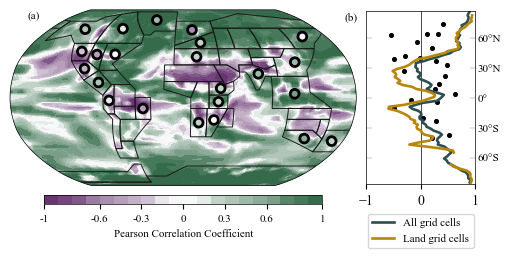

In [10]:
#Set Color Settings
cramp   = LinearSegmentedColormap.from_list('cramp',['#40004b','white','#00441b'],N=30)
cramp   = cmr.get_sub_cmap(cramp,0.1,0.9,N=20)
mlevels = np.array([i /10 for i in list(range(-10,11,2))])
m_1='trace'
#Set Lat/Lons
lats,lons = modelData[m_1][szn]['lat'],modelData[m_1][szn]['lon']
if regrid: name      = 'multi'+'_'+v_1+'_'+v_2+'_'+szn+'_'+str(times[0])+'to'+str(times[1])+'ka'
else: name      = m_1+'_'+v_1+'_'+v_2+'_'+szn+'_'+str(times[0])+'to'+str(times[1])+'ka'
    
#Plot
plt.figure(figsize=(6,3.01))
gs = gridspec.GridSpec(12,8)
ax0 = plt.subplot(gs[0:12,0:6],projection=ccrs.Robinson()) 
rm.defined_regions.ar6.land.plot_regions(ax=ax0,add_label=False,line_kws=dict(linewidth=0.7))
data_cyclic,lon_cyclic = cutil.add_cyclic_point(rVals,coord=lons)
model_contour = plt.contourf(lon_cyclic,lats, data_cyclic,transform=ccrs.PlateCarree(),vmin=-1,vmax=1,cmap=cramp,levels=20)  
ax0.set_global()
ax0.scatter(pltlons,pltlats,c=pltVals,transform=ccrs.PlateCarree(),cmap=cramp,vmin=-1,vmax=1,s=40,ec='k',lw=2)
ax0.annotate('(a)',xy=(0, 0), xycoords='data', xytext=(0.05, 0.95), 
            textcoords='axes fraction', fontsize=8, fontfamily = font)
cbar = plt.colorbar(model_contour,orientation="horizontal",ticks=[-1,-0.6,-0.3,0,0.3,0.6,1],
                        fraction=0.04, pad=0.04,aspect=30)
cbar.set_label('Pearson Correlation Coefficient',fontsize=8, fontfamily = font)
cbar.ax.set_xticklabels([-1,-0.6,-0.3,0,0.3,0.6,1],fontsize=8)


mask = rm.defined_regions.natural_earth.land_110.mask_3D(lons,lats).squeeze('region').data
 
ax1 = plt.subplot(gs[2:11,6:8]) 
rValsLand = np.full(np.shape(rVals),np.NaN) 
for lat in range(len(lats)):
    for lon in range(len(lons)):
        if mask[lat,lon]: rValsLand[lat,lon] = rVals[lat,lon]
ax1.annotate('(b)',xy=(0, 0), xycoords='data', xytext=(-0.2, 0.95), 
            textcoords='axes fraction', fontsize=8, fontfamily = font)
ax1.axvline(x=0,color='black',lw=0.5)
for i in range(-90,91,30):
    ax1.axhline(y=i,xmin=0,xmax=0.05,color='grey',lw=0.3)
    ax1.axhline(y=i,xmin=0.95,xmax=1,color='grey',lw=0.3)

ax1.axis([mlevels[0],mlevels[-1],lats[-2],lats[1]])

x = np.nanmean(rValsLand, axis=1) 
ax1.plot(np.nanmean(rVals,axis=1) ,lats,c='darkslategrey',lw=1.9,label='All grid cells')
ax1.plot(x,lats,'-',c='darkgoldenrod',lw=1.9,label='Land grid cells')
ax1.scatter(pltVals,pltlats,c='k',s=7)#plt.cm.get_cmap('BrBG',5),
#ax1.spines['right'].set_visible(False);ax1.spines['left'].set_visible(False)
ax1.invert_yaxis() 
ax1.set_yticklabels([-1,0,1],fontsize=8)
ax1.set_yticks([])
ax1.set_yticklabels([])
#
ax1.annotate('60'+u'\N{DEGREE SIGN}'+'S',xy=(0, 0), xycoords='data', xytext=(1.02, 0.135), 
            textcoords='axes fraction', fontsize=8, fontfamily = font)
ax1.annotate('30'+u'\N{DEGREE SIGN}'+'S',xy=(0, 0), xycoords='data', xytext=(1.02, 0.305), 
            textcoords='axes fraction', fontsize=8, fontfamily = font)
ax1.annotate('0'+u'\N{DEGREE SIGN}',     xy=(0, 0), xycoords='data', xytext=(1.02, 0.48), 
            textcoords='axes fraction', fontsize=8, fontfamily = font)
ax1.annotate('30'+u'\N{DEGREE SIGN}'+'N',xy=(0, 0), xycoords='data', xytext=(1.02, 0.65), 
            textcoords='axes fraction', fontsize=8, fontfamily = font)
ax1.annotate('60'+u'\N{DEGREE SIGN}'+'N',xy=(0, 0), xycoords='data', xytext=(1.02, 0.825), 
            textcoords='axes fraction', fontsize=8, fontfamily = font)
#
plt.legend(loc='lower center',fontsize=8,bbox_to_anchor=(0.5, -0.4))

#Save or show
if save: 
    plt.savefig('Figures/Model/TransientCorrelations/'+name+'.png', dpi=600,format='png', bbox_inches='tight')  
    print("plot saved")
plt.show()

In [11]:
rVals

array([[0.95047046, 0.9522167 , 0.95443986, ..., 0.9490854 , 0.94831669,
        0.94837397],
       [0.96375767, 0.96811089, 0.97218258, ..., 0.9552319 , 0.95706008,
        0.9593594 ],
       [0.98514639, 0.98157798, 0.97870077, ..., 0.98030658, 0.98282395,
        0.9844119 ],
       ...,
       [0.72377199, 0.7156234 , 0.70875946, ..., 0.75643464, 0.74046029,
        0.72853277],
       [0.78141393, 0.7895148 , 0.78629211, ..., 0.76296052, 0.77882502,
        0.7862152 ],
       [0.78173282, 0.79272615, 0.78974365, ..., 0.74988183, 0.77506779,
        0.78732017]])

'/Users/chrishancock/Library/CloudStorage/OneDrive-NorthernArizonaUniversity/Research/Manuscript/HoloceneHydroclimate/HoloceneHydroclimateData/RegionComposites/'